<a href="https://colab.research.google.com/github/mehran1373/wheather-forecasting/blob/main/weather_forecasting_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
# import ibraries
import numpy as np
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error,mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import itertools
from sklearn.impute import SimpleImputer
from random import randint
import warnings
warnings.filterwarnings('ignore')

In [155]:
data=pd.read_csv('/content/testset.csv')
data.columns=[i.split('_')[1] for i in data.columns]
data.head(3).T

0               1               2
utc         19961101-11:00  19961101-12:00  19961101-13:00
conds                Smoke           Smoke           Smoke
dewptm                 9.0            10.0            11.0
fog                      0               0               0
hail                     0               0               0
heatindexm             NaN             NaN             NaN
hum                   27.0            32.0            44.0
precipm                NaN             NaN             NaN
pressurem           1010.0         -9999.0         -9999.0
rain                     0               0               0
snow                     0               0               0
tempm                 30.0            28.0            24.0
thunder                  0               0               0
tornado                  0               0               0
vism                   5.0             NaN             NaN
wdird                280.0             0.0             0.0
wdire                 West           North           North
wgustm                 NaN             NaN             NaN
windchillm             NaN             NaN             NaN
wspdm                  7.4             NaN             NaN

In [156]:
data.shape

(100990, 20)

 handling *missing* values


In [157]:
name=[]
total=[]
percent=[]
for i in data.columns:
  if (data[i].isnull().sum()).any() >0 :
    name.append(i)
    total.append(data[i].isnull().sum())
    percent.append(round((data[i].isnull().sum())/(data.shape[0])*100,2
                         ))

df_null=pd.DataFrame({'name':name,'total':total,'percent %':percent})
df_null    

name   total  percent %
0        conds      72       0.07
1       dewptm     621       0.61
2   heatindexm   71835      71.13
3          hum     757       0.75
4      precipm  100990     100.00
5    pressurem     232       0.23
6        tempm     673       0.67
7         vism    4428       4.38
8        wdird   14755      14.61
9        wdire   14755      14.61
10      wgustm   99918      98.94
11  windchillm  100411      99.43
12       wspdm    2358       2.33

In [158]:
null_percent=list(df_null['percent %'])
null_name=list(df_null['name'])
null=list()
for i,j in zip(null_name,null_percent):
  if j>10:
    null.append(i)
null    

['heatindexm', 'precipm', 'wdird', 'wdire', 'wgustm', 'windchillm']

In [159]:
data=data.drop(columns=null)

In [160]:
for i in data.columns:
  if data[i].dtype=='object':
    data[i]=SimpleImputer(strategy='most_frequent').fit_transform(data[i].values.reshape(-1,1))
  else:
    data[i]=SimpleImputer(strategy='median').fit_transform(data[i].values.reshape(-1,1))  

In [161]:
data.isnull().sum()

utc          0
conds        0
dewptm       0
fog          0
hail         0
hum          0
pressurem    0
rain         0
snow         0
tempm        0
thunder      0
tornado      0
vism         0
wspdm        0
dtype: int64

feature enginering

In [162]:
data['utc']=pd.to_datetime(data['utc'],format='%Y%m%d-%H:%M')
data['year']=data['utc'].dt.year
data['month']=data['utc'].dt.month_name()
data['day']=data['utc'].dt.day
data['day_name']=data['utc'].dt.day_name()
data['hour']=data['utc'].dt.hour

In [163]:
data=data.set_index('utc')
data

conds  dewptm  fog  hail   hum  pressurem  rain  snow  \
utc                                                                          
1996-11-01 11:00:00  Smoke     9.0  0.0   0.0  27.0     1010.0   0.0   0.0   
1996-11-01 12:00:00  Smoke    10.0  0.0   0.0  32.0    -9999.0   0.0   0.0   
1996-11-01 13:00:00  Smoke    11.0  0.0   0.0  44.0    -9999.0   0.0   0.0   
1996-11-01 14:00:00  Smoke    10.0  0.0   0.0  41.0     1010.0   0.0   0.0   
1996-11-01 16:00:00  Smoke    11.0  0.0   0.0  47.0     1011.0   0.0   0.0   
...                    ...     ...  ...   ...   ...        ...   ...   ...   
2017-04-24 06:00:00   Haze    17.0  0.0   0.0  25.0     1005.0   0.0   0.0   
2017-04-24 09:00:00   Haze    14.0  0.0   0.0  16.0     1003.0   0.0   0.0   
2017-04-24 12:00:00   Haze    12.0  0.0   0.0  14.0     1002.0   0.0   0.0   
2017-04-24 15:00:00   Haze    15.0  0.0   0.0  27.0     1004.0   0.0   0.0   
2017-04-24 18:00:00   Haze    15.0  0.0   0.0  30.0     1005.0   0.0   0.0   

                     tempm  thunder  tornado  vism  wspdm  year     month  \
utc                                                                         
1996-11-01 11:00:00   30.0      0.0      0.0   5.0    7.4  1996  November   
1996-11-01 12:00:00   28.0      0.0      0.0   2.0    7.4  1996  November   
1996-11-01 13:00:00   24.0      0.0      0.0   2.0    7.4  1996  November   
1996-11-01 14:00:00   24.0      0.0      0.0   2.0    7.4  1996  November   
1996-11-01 16:00:00   23.0      0.0      0.0   1.2    0.0  1996  November   
...                    ...      ...      ...   ...    ...   ...       ...   
2017-04-24 06:00:00   34.0      0.0      0.0   4.0   11.1  2017     April   
2017-04-24 09:00:00   38.0      0.0      0.0   4.0   22.2  2017     April   
2017-04-24 12:00:00   36.0      0.0      0.0   4.0   18.5  2017     April   
2017-04-24 15:00:00   32.0      0.0      0.0   2.0    3.7  2017     April   
2017-04-24 18:00:00   30.0      0.0      0.0   2.0    3.7  2017     April   

                     day day_name  hour  
utc                                      
1996-11-01 11:00:00    1   Friday    11  
1996-11-01 12:00:00    1   Friday    12  
1996-11-01 13:00:00    1   Friday    13  
1996-11-01 14:00:00    1   Friday    14  
1996-11-01 16:00:00    1   Friday    16  
...                  ...      ...   ...  
2017-04-24 06:00:00   24   Monday     6  
2017-04-24 09:00:00   24   Monday     9  
2017-04-24 12:00:00   24   Monday    12  
2017-04-24 15:00:00   24   Monday    15  
2017-04-24 18:00:00   24   Monday    18  

[100990 rows x 18 columns]

**EDA**

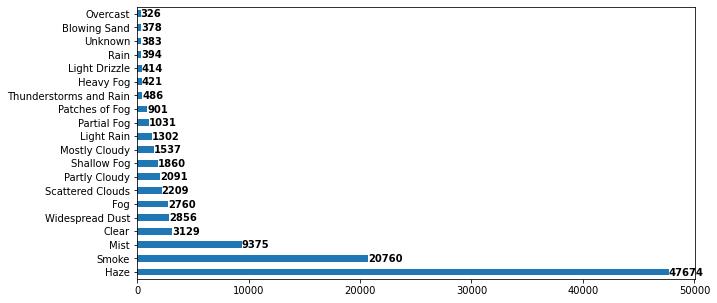

In [ ]:
fig,ax=plt.subplots(figsize=(10,5))
ax=data['conds'].value_counts().head(20).plot(kind='barh')
for i in ax.patches:
  plt.text(x=i.get_width(),y=i.get_y(),s=i.get_width(),fontweight='bold')

over view of numerical variables

In [ ]:
numerical=data.iloc[:,1:13]

In [ ]:
#plt.figure(figsize=(15,10))# create a histplot for every columns in numerical dataframe
#for i,j in enumerate(numerical.columns):
  #ax=plt.subplot(3,3,i+1)
  #sns.histplot(data=numerical,x=j,ax=ax)


In [164]:
color=[]
for i in sns.color_palette(None,20):
  color.append(i)

Text(0.5, 0.98, 'climate change in day')

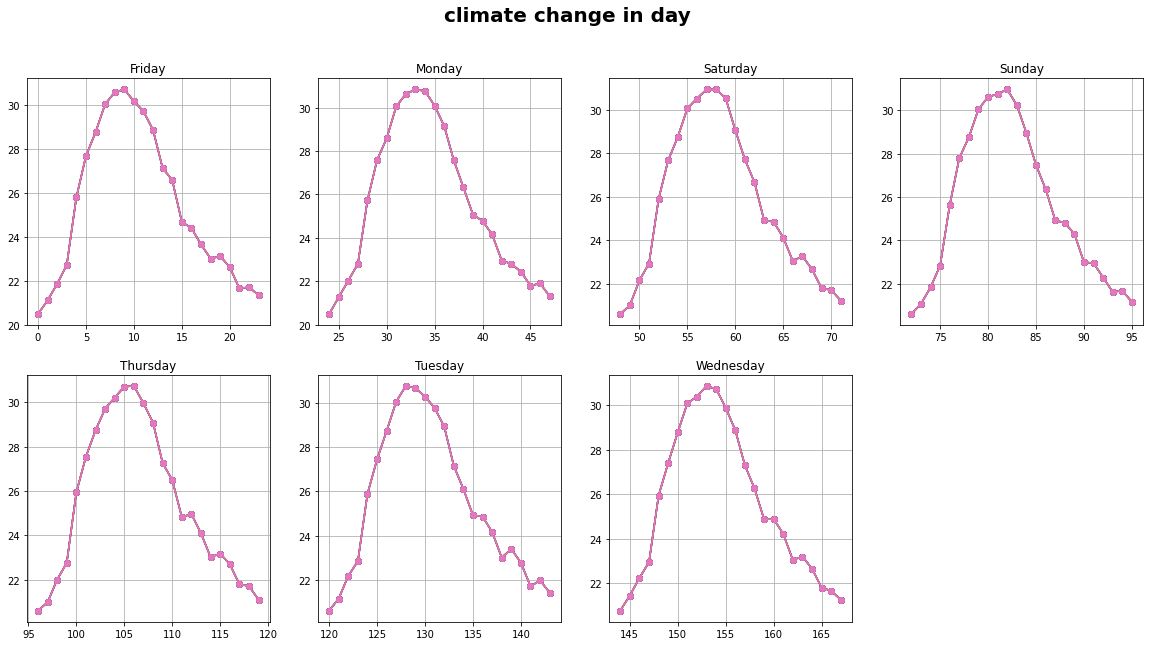

In [165]:
temp_cond=data.groupby(['day_name','hour'])['tempm'].mean().reset_index()
plt.figure(figsize=(20,10))
for i,j in enumerate(temp_cond['day_name'].unique()):
  for c,p in zip(color,temp_cond['day_name'].unique()):
    ax=plt.subplot(2,4,i+1)
    temp_cond[temp_cond['day_name']==j]['tempm'].plot(ax=ax,marker='o',color=c)
    ax.set_title(j)
    plt.grid()
plt.suptitle('climate change in day',fontweight='bold',fontsize=20)  


Text(0.5, 0.98, 'change climate in month')

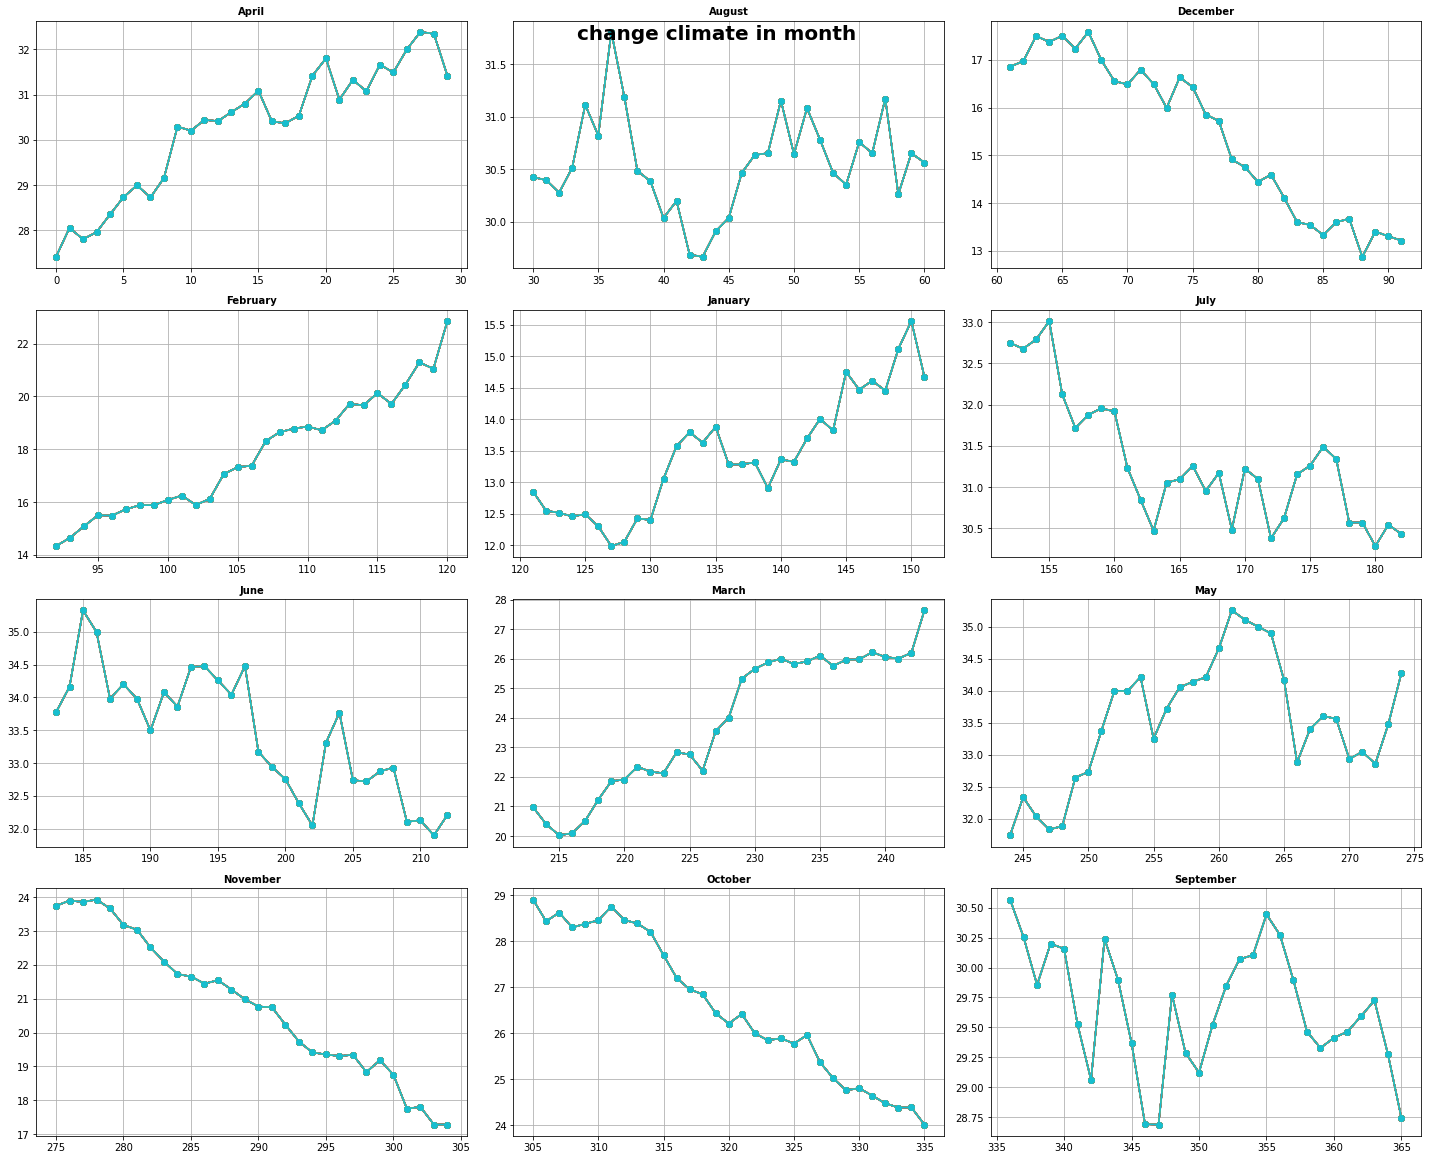

In [199]:
temp_month=data.groupby(['month','day'])['tempm'].mean().reset_index()
plt.figure(figsize=(20,20))
for i,j in enumerate(temp_month['month'].unique()):
  for c in color:
    ax=plt.subplot(5,3,i+1)
    temp_month[temp_month['month']==j]['tempm'].plot(marker='o',color=c)
    ax.set_title(j,fontweight='bold',
                 size='10')
    plt.grid()
plt.tight_layout()
plt.suptitle('change climate in month',fontweight='bold',fontsize='20')

Text(0.5, 1.0, 'climate change by year')

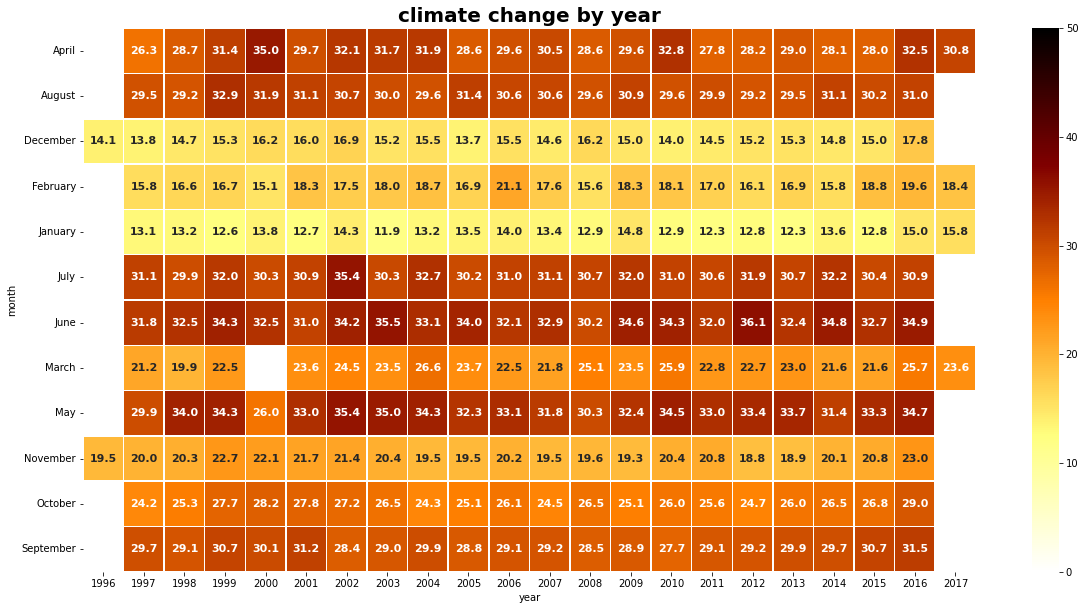

In [ ]:
plt.figure(figsize=(20,10))
year_temp=data.groupby(['year','month'])['tempm'].mean().reset_index()
year_temp_pivot=pd.pivot_table(index='month',columns='year',values='tempm',aggfunc='mean',data=year_temp)
sns.heatmap(year_temp_pivot,annot=True,fmt='.1f',cmap='afmhot_r',vmin=0,vmax=50,annot_kws=dict(fontweight='bold',size=11),linewidth=0.5).set_title('climate change by year',fontweight='bold',size=20)

In [166]:

total=data.groupby(['day_name','hour','conds']).agg({'tempm':'mean','pressurem':['mean',max,min],'wspdm':['mean',max,min],'vism':['mean',max,min]}).reset_index()
total.style.background_gradient(axis=0)

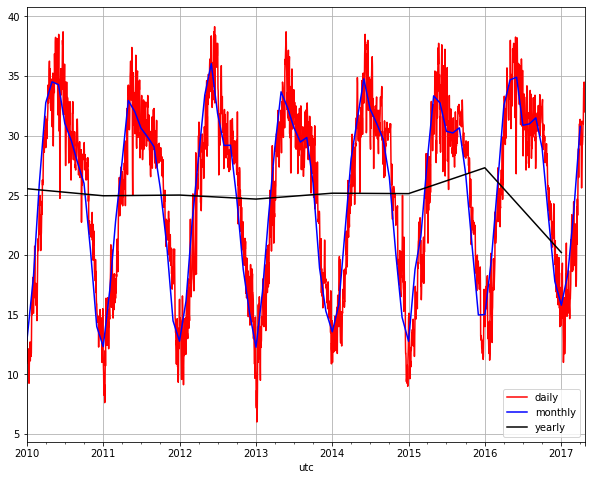

In [168]:
data=data.loc['2010-1-1':]
plt.figure(figsize=(10,8))
daily=data['tempm'].resample('D').mean().plot(color='red',label='daily')
monthly=data['tempm'].resample('M').mean().plot(color='blue',label='monthly')
yearly=data['tempm'].resample('Y').mean().plot(color='black',label='yearly')
plt.legend(loc='best')
plt.grid()

**decomposing**

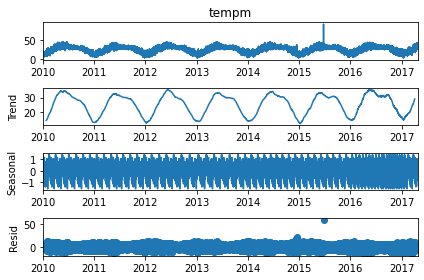

In [170]:

decomposing=seasonal_decompose(x=data['tempm'],period=365,model='additive').plot()

In [172]:
#stationary

def check_stationary(ts):
  adf=adfuller(ts)
  ts.rolling(12).mean().plot(label='mean')
  ts.rolling(12).std().plot(label='std',color='red')
  ts.plot(color='green',label='original')
  plt.legend()
  print('P-value :{}'.format(adf[1]))
  if adf[1] < 0.05:
    print('-----stationary-----')
  else:
    print('----- Nonstationary----')
  print('critical :{}'.format(adf[0]),2*'\n')
  for key ,value in adf[4].items():
        print('{}: {}'.format(key,value))

P-value :0.001632598285365728
-----stationary-----
critical :-3.960411917917824 


1%: -3.4306192795028743
5%: -2.8616590132334103
10%: -2.566833347291085


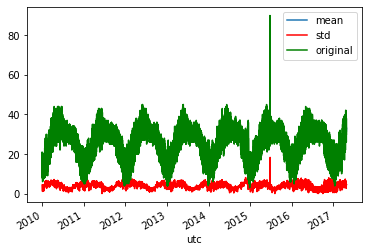

In [173]:
check_stationary(data['tempm'])

In [174]:
temp_log=np.log(data['tempm'])
temp_diff=temp_log.diff().diff().dropna()

P-value :0.0
-----stationary-----
critical :-45.93907698443611 


1%: -3.4306193127726785
5%: -2.8616590279369705
10%: -2.5668333551174793


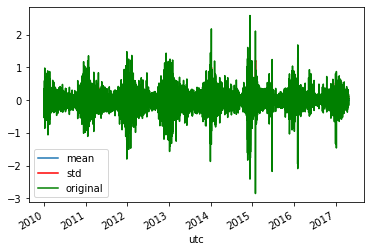

In [175]:
check_stationary(temp_diff)

In [176]:
split=int(len(data)*0.8)
train=data['tempm'][:split].to_frame()
test=data['tempm'][split:].to_frame()
train.shape,test.shape


((19468, 1), (4867, 1))

In [84]:
p=d=q=range(0,2)
pdq=list(itertools.product(p,d,q))
seasonal=[(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]
order=[]
seasonal_order=[]
aic=[]
for i in pdq:
  for j in seasonal:
       model=SARIMAX(train,order=i,seasonal_order=j)
       result=model.fit()
       order.append(i)
       seasonal_order.append(j)
       aic.append(result.aic)
df=pd.DataFrame({'order':order,'seasonal_order':seasonal_order,'aic':aic})
df.sort_values(by='aic',ascending=False)       
 

order seasonal_order            aic
0   (0, 0, 0)  (0, 0, 0, 12)  183582.334945
1   (0, 0, 0)  (0, 0, 1, 12)  167479.901683
8   (0, 0, 1)  (0, 0, 0, 12)  160017.178761
9   (0, 0, 1)  (0, 0, 1, 12)  145687.743741
2   (0, 0, 0)  (0, 1, 0, 12)  130667.260278
..        ...            ...            ...
61  (1, 1, 1)  (1, 0, 1, 12)  104091.976638
39  (1, 0, 0)  (1, 1, 1, 12)  103087.273932
45  (1, 0, 1)  (1, 0, 1, 12)  101719.118900
43  (1, 0, 1)  (0, 1, 1, 12)  101644.535186
47  (1, 0, 1)  (1, 1, 1, 12)  101055.511226

[64 rows x 3 columns]

In [177]:
model=SARIMAX(train,order=(1,0,1),seasonal_order=(1,1,1,12)).fit()

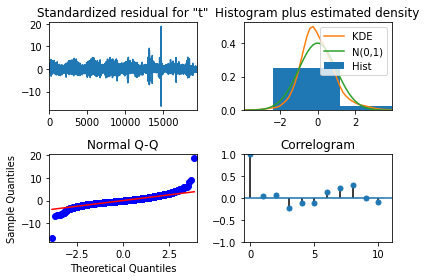

In [178]:
model.plot_diagnostics()
plt.tight_layout()

In [179]:
start=len(train)
end=(len(train)+len(test)-1)

In [180]:
predict=model.get_prediction(start=start,end=end)

In [181]:
predict_values=predict.predicted_mean
predict_values

19468    29.284897
19469    29.487042
19470    29.149563
19471    29.024863
19472    29.144148
           ...    
24330    29.341886
24331    29.214794
24332    29.137203
24333    28.739893
24334    28.952132
Name: predicted_mean, Length: 4867, dtype: float64

In [182]:
conf=predict.conf_int()
conf

lower tempm  upper tempm
19468    22.923601    35.646194
19469    20.808111    38.165972
19470    19.852704    38.446423
19471    19.539548    38.510178
19472    19.599562    38.688735
...            ...          ...
24330     3.193597    55.490175
24331     3.065424    55.364163
24332     2.987489    55.286917
24333     2.590070    54.889717
24334     2.802274    55.101991

[4867 rows x 2 columns]

**RMSE**

In [183]:
print('RMSE is: {}'.format(mean_squared_error(test,predict_values)))

RMSE is: 80.57421444873073
